<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center>Assignment #6
### <center> Beating baselines in "How good is your Medium article?"
    
<img src='../../img/medium_claps.jpg' width=40% />


[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "A6 baseline" (~1.45 Public LB score). Do not forget about our shared ["primitive" baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline) - you'll find something valuable there.

**Your task:**
 1. "Freeride". Come up with good features to beat the baseline "A6 baseline" (for now, public LB is only considered)
 2. You need to name your [team](https://www.kaggle.com/c/how-good-is-your-medium-article/team) (out of 1 person) in full accordance with the [course rating](https://drive.google.com/open?id=19AGEhUQUol6_kNLKSzBsjcGUU3qWy3BNUg8x8IFkO3Q). You can think of it as a part of the assignment. 16 credits for beating the mentioned baseline and correct team naming.

In [2]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge

The following code will help to throw away all HTML tags from an article content.

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [4]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [5]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            
            # You code here
            for i in range(len(features)):
                content = str(json_data[features[i]]).replace('\n', ' ').replace('\r', ' ')
                content_no_html_tags = strip_tags(content)
                feature_files[i].write(str(content_no_html_tags) + '\n')
                #feature_files[i].write(str(json_data[features[i]]) + '\n')

In [6]:
PATH_TO_DATA = '../../data/kaggle_medium' # modify this if you need to

In [7]:
#os.listdir()

In [8]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [9]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [ ]:
# You code here
def TfIdf(path_to_data, inp_filename):
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1,2),stop_words='english')
    X = vectorizer.fit_transform(content)
    print(vectorizer.get_feature_names()[:10])
#     print(X.shape)
    return X, vectorizer

In [ ]:
X_train_content_sparse, vect_content = TfIdf(PATH_TO_DATA, 'train_content.txt')
X_train_title_sparse, vect_title = TfIdf(PATH_TO_DATA, 'train_title.txt')
#print(X_train_title_sparse.shape)

['00', '00 00', '00 greve', '00 pm', '000', '000 00', '000 000', '000 10', '000 100', '000 50']
['00', '000', '000 000', '000 blog', '000 cold', '000 day', '000 google', '000 kickstarter', '000 miles', '000 month']


In [ ]:
print(vect_content.get_feature_names()[:10])
print(vect_title.get_feature_names()[:10])
#     print(X.shape)

['00', '00 00', '00 greve', '00 pm', '000', '000 00', '000 000', '000 10', '000 100', '000 50']
['00', '000', '000 000', '000 blog', '000 cold', '000 day', '000 google', '000 kickstarter', '000 miles', '000 month']


In [ ]:
import scipy.sparse
scipy.sparse.save_npz('../../data/kaggle_medium/train_title_matrix_stopword.npz',X_train_title_sparse) 

In [ ]:
scipy.sparse.save_npz('../../data/kaggle_medium/train_content_matrix_stopword.npz',X_train_content_sparse) 

In [ ]:
X_train_content_sparse.shape

(62313, 100000)

In [ ]:
X_train_title_sparse.shape

(62313, 100000)

In [ ]:
def TfIdf_test(path_to_data, inp_filename, vectorizer):
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    X = vectorizer.transform(content)
    #print(vectorizer.get_feature_names()[:10])
#     print(X.shape)
    return X

In [ ]:
X_test_content_sparse = TfIdf_test(PATH_TO_DATA, 'test_content.txt', vect_content)
X_test_title_sparse = TfIdf_test(PATH_TO_DATA, 'test_title.txt', vect_title)
scipy.sparse.save_npz('../../data/kaggle_medium/test_title_matrix_stopword.npz', X_test_title_sparse)
scipy.sparse.save_npz('../../data/kaggle_medium/test_content_matrix_stopword.npz', X_test_content_sparse)

In [ ]:
print(X_test_content_sparse.shape)

(34645, 100000)


In [ ]:
print(X_test_title_sparse.shape)

(34645, 100000)


In [ ]:
def timeFeature(path_to_data, inp_filename):
    df_published = pd.read_csv(os.path.join(path_to_data, inp_filename),
                             sep = " ", header = None)
    df_published.columns = ['tag', 'date']
    df_published.date = df_published.date.str.replace(r'}$', '')
    df_published['date'] = pd.to_datetime(df_published['date'])
    df_published['year'] = df_published.date.dt.year
    df_published['month'] = df_published.date.dt.month
    df_published['dow'] = df_published.date.dt.dayofweek
    df_published['hour'] = df_published.date.dt.hour
    df_published['morning'] = (df_published['hour'] <= 9) & (df_published['hour'] >= 6)
    df_published['day'] = (df_published['hour'] <= 18) & (df_published['hour'] > 9)
    df_published['night'] = (df_published['hour'] > 18) | (df_published['hour'] < 6)
    df_published['isWeekend'] = df_published.date.dt.dayofweek >= 5
    df_published = df_published.drop(columns=['tag','date'])
    return df_published.astype(int).values

In [ ]:
X_train_time_features_sparse = timeFeature(PATH_TO_DATA, 'train_published.txt')
X_train_time_features_sparse

array([[22,  0,  0,  1,  0],
       [ 7,  1,  0,  0,  0],
       [13,  0,  1,  0,  1],
       ...,
       [ 6,  1,  0,  0,  1],
       [17,  0,  1,  0,  1],
       [ 3,  0,  0,  1,  0]])

In [ ]:
print(X_train_time_features_sparse.shape)

(62313, 5)


In [ ]:
X_test_time_features_sparse = timeFeature(PATH_TO_DATA, 'test_published.txt')
print(X_test_time_features_sparse.shape)

(34645, 5)


In [25]:
# def authorFeature(path_to_data, inp_filename):
#     df_author = pd.read_csv(os.path.join(PATH_TO_DATA, inp_filename), sep=' ', header = None)
#     df_author.columns = ['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'twitter']
#     df_author.twitter = df_author.twitter.str.replace(r'}$', '')
#     one_hot = pd.get_dummies(df_author['twitter'])
#     df_author = df_author.join(one_hot)
#     df_author = df_author.drop(columns=['tag0', 'tag1','tag2','tag3','tag4','twitter'])
#     return df_author.values

In [26]:
df_author = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_author.txt'), sep=' ', header = None)
df_author.columns = ['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'twitter']
df_author.twitter = df_author.twitter.str.replace(r'}$', '')
cat_columns = ['twitter']
df_author_processed = pd.get_dummies(df_author, prefix_sep="__", columns=cat_columns)
df_author_processed.head()

,tag0,tag1,tag2,tag3,tag4,twitter__'@0723Sam',twitter__'@0canom',twitter__'@0guzKilic',twitter__'@0ptionworkshop',twitter__'@0rf',...,twitter__'@zumpang',twitter__'@zvellas',twitter__'@zverk0',twitter__'@zysman',twitter__'@zzam_',twitter__'@zzbennett',twitter__'@zzdoublezz',twitter__'@zzilch',twitter__'@zzste',twitter__None
0,{'name':,"None,",'url':,"'https://medium.com/@Medium',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,{'name':,"None,",'url':,"'https://medium.com/@Medium',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,{'name':,"None,",'url':,"'https://medium.com/@aelcenganda',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,{'name':,"None,",'url':,"'https://medium.com/@vaibhavkhulbe',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,{'name':,"None,",'url':,"'https://medium.com/@vaibhavkhulbe',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
cat_dummies = [col for col in df_author_processed 
               if "__" in col 
               and col.split("__")[0] in cat_columns]
# cat_dummies

In [28]:
processed_columns = list(df_author_processed.columns[:])

In [29]:
df_author_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_author.txt'), sep=' ', header = None)
df_author_test.columns = ['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'twitter']
df_author_test.twitter = df_author_test.twitter.str.replace(r'}$', '')
df_author_test.head()

,tag0,tag1,tag2,tag3,tag4,twitter
0,{'name':,"None,",'url':,"'https://medium.com/@HITRECORD.org',",'twitter':,'@hitRECord'
1,{'name':,"None,",'url':,"'https://medium.com/@mariabustillos',",'twitter':,'@mariabustillos'
2,{'name':,"None,",'url':,"'https://medium.com/@HITRECORD.org',",'twitter':,'@hitRECord'
3,{'name':,"None,",'url':,"'https://medium.com/@LanceUlanoff',",'twitter':,'@LanceUlanoff'
4,{'name':,"None,",'url':,"'https://blog.medium.com/@Medium',",'twitter':,'@Medium'


In [ ]:
df_test_processed = pd.get_dummies(df_author_test, prefix_sep="__", 
                                   columns=cat_columns)
df_test_processed.head()

,tag0,tag1,tag2,tag3,tag4,twitter__'@007_drive',twitter__'@02215507',twitter__'@08181',twitter__'@0guzKilic',twitter__'@0x0ece',...,twitter__'@zntfdr',twitter__'@zoeschlag',twitter__'@zopsesen',twitter__'@zoyander',twitter__'@zs',twitter__'@zslayback',twitter__'@ztsamudzi',twitter__'@zuosisi44',twitter__'@zvona',twitter__None
0,{'name':,"None,",'url':,"'https://medium.com/@HITRECORD.org',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,{'name':,"None,",'url':,"'https://medium.com/@mariabustillos',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,{'name':,"None,",'url':,"'https://medium.com/@HITRECORD.org',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,{'name':,"None,",'url':,"'https://medium.com/@LanceUlanoff',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,{'name':,"None,",'url':,"'https://blog.medium.com/@Medium',",'twitter':,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Remove additional columns
for col in df_test_processed.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        #print("Removing additional feature {}".format(col))
        df_test_processed.drop(col, axis=1, inplace=True)
        
df_test_processed.head()

In [ ]:
for col in cat_dummies:
    if col not in df_test_processed.columns:
        #print("Adding missing feature {}".format(col))
        df_test_processed[col] = 0
df_test_processed.head()

In [ ]:
df_test_processed = df_test_processed[processed_columns]
df_test_processed.head()

In [ ]:
df_author_processed = df_author_processed.drop(columns=['tag0', 'tag1', 'tag2', 'tag3', 'tag4'])
X_train_author_sparse = df_author_processed.values
df_test_processed = df_test_processed.drop(columns=['tag0', 'tag1', 'tag2', 'tag3', 'tag4'])
X_test_author_sparse = df_test_processed.values
print(X_train_author_sparse.shape)
print(X_test_author_sparse.shape)

In [ ]:
np.save(os.path.join(PATH_TO_DATA, 'X_train_author_sparse.npy'), X_train_author_sparse)
np.save(os.path.join(PATH_TO_DATA, 'X_test_author_sparse.npy'), X_test_author_sparse)

In [114]:
type(X_train_author_sparse)
type(X_train_content_sparse)
# type(X_train_time_features_sparse)
# type(X_train_title_sparse)

scipy.sparse.csr.csr_matrix

In [120]:
X_train_author_sparse = csr_matrix(X_train_author_sparse)
X_train_time_features_sparse = csr_matrix(X_train_time_features_sparse)

**Join all sparse matrices.**

In [150]:
X_train_sparse = hstack([X_train_content_sparse, X_train_title_sparse,
                         X_train_author_sparse, 
                         X_train_time_features_sparse]).tocsr()

In [151]:
X_test_sparse = hstack([X_test_content_sparse, X_test_title_sparse,
                        X_test_author_sparse, 
                        X_test_time_features_sparse]).tocsr()

**Read train target and split data for validation.**

In [124]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [152]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [164]:
# You code here
ridge = Ridge(random_state=17)
ridge.fit(X_train_part_sparse, y_train_part)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [165]:
ridge_pred = ridge.predict(X_valid_sparse)
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae

1.086391615411802

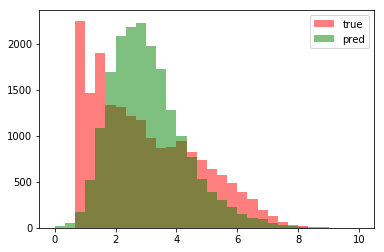

In [135]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [155]:
# You code here
ridge.fit(X_train_sparse, y_train)
ridge_test_pred = ridge.predict(X_test_sparse)

In [130]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [132]:
write_submission_file(ridge_test_pred, os.path.join(PATH_TO_DATA,
                                                    'assignment6_medium_submission.csv'))

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [133]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))

In [136]:
score = 4.33328

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [160]:
ridge_test_pred_modif = np.median(ridge_test_pred)#(ridge_test_pred + score) / 2# You code here
print(ridge_test_pred_modif)

2.988730393775304


In [161]:
write_submission_file(ridge_test_pred_modif, 
                      os.path.join(PATH_TO_DATA,
                                   'assignment6_medium_submission_with_hack.csv'))

That's it for the assignment. Much more credits will be given to the winners in this competition, check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with MAE < 1.5).

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

<img src='../../img/kaggle_shakeup.png' width=50%>